# Car Price Prediction Project

## Project Details

- **Project Title:** Car Price Prediction
- **Goal:** Establish, justify and lock the best modeling approach
- **Target:** Price
- **Task:** Supervised Learning (Regression)
- **Metric:** 
  - Primary: RMSE
  - Secondary: MAE
- **Validation:** K-Fold Cross-Validation
- **Success Criterion:** Stable RMSE across folds
- **Deployment Intent:** One validated pipeline ready for deployment


In [2]:
# Import neccessary libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score, KFold, GridSearchCV, RandomizedSearchCV,
    TimeSeriesSplit
)
from preprocessing import (clean_categorical, clean_numerical, engineered_features) # my cleaning function and feature engineering

In [3]:
#import dataset
df = pd.read_csv('car_price_with_errors.csv')

print(df.columns)
df.head()

Index(['Make', 'Model', 'Year', 'Engine Size', 'Mileage', 'Fuel Type',
       'Transmission', 'Price'],
      dtype='object')


,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price
0,Toyota-,Civic,1996.0,5.0,212102.0,Hybrid,AuTOmATIc,66758.0
1,Toyota,Corolla,1999.0,3.9,293523.0,Hybrid.,Automatic,9774.0
2,Ford,Focus_,2010.0,-4.5,288885.0,Diesel,Automatic,42732.0
3,Honda-,C-Class,2020.0,2.1,216759.0,PETroL,Automatic,45986.0
4,Honda,C-Class,1997.0,2.3,280277.0,Petrol,Automatic,0.0


In [4]:
expected_columns = {
    'Make', 'Model', 'Year', 'Engine Size', 'Mileage', 'Fuel Type',
       'Transmission', 'Price'
}

missing_cols = expected_columns - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing required colums: {missing_cols}")

In [5]:
# Separate numerical and categorical columns
cat_features = df.select_dtypes(include="object").columns.tolist()
num_features =df.select_dtypes(include=["int64", "float64"]).columns.drop("Price", errors="ignore").tolist()
cat_features, num_features

(['Make', 'Model', 'Fuel Type', 'Transmission'],
 ['Year', 'Engine Size', 'Mileage'])

In [6]:
# Model pipelines

# Categorical pipeline for linear model
cat_pipeline = Pipeline(steps=[
    ("clean", FunctionTransformer(clean_categorical, validate=False)),
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Numerical pipeline for linear model
num_linear_pipeline = Pipeline(steps=[
    ("clean", FunctionTransformer(clean_numerical, validate=False)),
    ("engineer", FunctionTransformer(engineered_features)),
    ("impute", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Numerical pipeline for tree model
num_tree_pipeline = Pipeline(steps=[
    ("clean", FunctionTransformer(clean_numerical, validate=False)),
    ("engineer", FunctionTransformer(engineered_features)),
    ("impute", SimpleImputer(strategy='mean'))
])


# Wrap in a transformer
linear_preprocessor = ColumnTransformer(transformers=[
    ("cat", cat_pipeline, cat_features),
    ("num", num_linear_pipeline, num_features)
])

tree_preprocessor = ColumnTransformer(transformers=[
    ("cat", cat_pipeline, cat_features),
    ("num", num_tree_pipeline, num_features)
])

In [7]:
# Remove negative and zero prices before defining X and y
df_cv = df[df['Price']>0].copy()

#create new column for time based splitting
current_year = 2025
min_year = 1925
df_cv = df_cv.copy()
df_cv['Year'] = df_cv['Year'].where(df_cv['Year'].between(min_year, current_year))
df_cv = (
    df_cv
    .dropna(subset=['Year'])
    .sort_values('Year', ascending=True)
    .reset_index(drop=True)
)

# Build X and y from the filtered frame
X = df_cv.drop("Price", axis=1)
y_linear = np.log1p(df_cv["Price"]) # for linear regression
y_tree = df_cv["Price"] # for random forest


In [8]:
# Timebased train and holdout split

split_point = int(len(df_cv) * 0.8)
train_X, holdout_X = X.iloc[:split_point], X.iloc[split_point:]
train_y_tree, holdout_y_tree = y_tree.iloc[:split_point], y_tree.iloc[split_point:]
train_y_linear, holdout_y_linear = y_linear.iloc[:split_point], y_linear.iloc[split_point:]

In [9]:
# We evaluate RMSE for linear in real price not log-RMSE
def real_rmse_scorer(estimator, X, y_linear):
    preds_log = estimator.predict(X)
    real_preds = np.expm1(preds_log)
    real_y = np.expm1(y_linear)
    
    return -np.sqrt(mean_squared_error(real_y, real_preds))

In [10]:
# Model definitions
elastic_pipeline = Pipeline(steps=[
    ("preprocessor", linear_preprocessor),
    ("model", ElasticNet(random_state=42, max_iter= 5000))
])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", tree_preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", tree_preprocessor),
    ("model", XGBRegressor(random_state=42, n_jobs=1))
])

lgbm_pipeline = Pipeline(steps=[
    ("preprocessor", tree_preprocessor),
    ("model", LGBMRegressor(random_state=42, n_jobs=1))
])


In [11]:
# Time aware cross validation and hyperparameter tuning

cv = TimeSeriesSplit(n_splits = 5)

#Parameter grids
elastic_params = {
    "model__alpha": [0.01, 0.1, 1.0],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}

rf_params = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 20],
    "model__min_samples_leaf": [1,3]
}

xgb_params = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [4, 6],
    "model__learning_rate": [0.05, 0.1]
}

lgbm_params = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [4, 6],
    "model__learning_rate": [0.05, 0.1]
}

In [12]:
# Grid search

"""
Note: ElasticNet is trained on log(price),
Custom scorer converts predictions back to real price,
RMSE is evaluated in real-price space for fair comparison
"""

elastic_gs = GridSearchCV(
    elastic_pipeline, elastic_params, cv=cv,
    scoring = real_rmse_scorer, n_jobs = -1
).fit(train_X, train_y_linear)

rf_gs = RandomizedSearchCV(               # Gridsearch is expensive for tree models
    rf_pipeline, rf_params, cv=cv,
    scoring = "neg_root_mean_squared_error", n_jobs=-1
).fit(train_X, train_y_tree)

xgb_gs = RandomizedSearchCV(
    xgb_pipeline, xgb_params, cv=cv,
    scoring = "neg_root_mean_squared_error", n_jobs=-1
).fit(train_X, train_y_tree)

lgbm_gs = RandomizedSearchCV(
    lgbm_pipeline, lgbm_params, cv=cv,
    scoring = "neg_root_mean_squared_error", n_jobs=-1
).fit(train_X, train_y_tree)




C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 687, number of used features: 19
[LightGBM] [Info] Start training from score 46509.987917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [13]:
# Model selection and validation

def cv_rmse_summary(search, model_name):  # Extract CV RMSE mean, std and stability ratio.
    
    mean_scores = search.cv_results_["mean_test_score"]
    std_scores = search.cv_results_["std_test_score"]

    best_idx = search.best_index_

    rmse_mean = abs(mean_scores[best_idx])
    rmse_std = std_scores[best_idx]

    return {
        "Model": model_name,
        "CV_RMSE_Mean": rmse_mean,
        "CV_RMSE_Std": rmse_std,
        "Stability_Ratio": rmse_std / rmse_mean
    }




In [14]:
# Collect CV results for training data
cv_results = []

cv_results.append(cv_rmse_summary(elastic_gs, "ElasticNet"))
cv_results.append(cv_rmse_summary(rf_gs, "RandomForest"))
cv_results.append(cv_rmse_summary(xgb_gs, "XGBoost"))
cv_results.append(cv_rmse_summary(lgbm_gs, "LightGBM"))

results_df = (
    pd.DataFrame(cv_results)
    .sort_values("CV_RMSE_Mean")
    .reset_index(drop=True)
)

print("\nCross-validated model comparison:")
print(results_df)



Cross-validated model comparison:
          Model  CV_RMSE_Mean  CV_RMSE_Std  Stability_Ratio
0    ElasticNet  36251.650227  7005.887431         0.193257
1  RandomForest  36879.788728  5523.221347         0.149763
2      LightGBM  37318.748892  6012.430318         0.161110
3       XGBoost  42703.160400  4766.236006         0.111613


In [15]:
# Stability gate

max_stability_ratio = 0.15   # business/engineering threshold

stable_models = results_df[
    results_df["Stability_Ratio"] <= max_stability_ratio
]

if stable_models.empty:
    raise ValueError("No model is stable enough for deployment.")
else:
    print("There is a stable model for deployment")


There is a stable model for deployment


In [16]:
# final model registry
model_registry = {
    "ElasticNet": elastic_gs.best_estimator_,
    "RandomForest": rf_gs.best_estimator_,
    "XGBoost": xgb_gs.best_estimator_,
    "LightGBM": lgbm_gs.best_estimator_,
}


# Hold-out evaluation

holdout_scores = {}

for model_name in stable_models["Model"]:
    model = model_registry[model_name]

    if model_name == "ElasticNet":
        preds = np.expm1(model.predict(holdout_X))
        y_true = np.expm1(holdout_y_linear)
    else:
        preds = model.predict(holdout_X)
        y_true = holdout_y_tree

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    holdout_scores[model_name] = rmse



print("\nHold-out RMSE results:")
for model, rmse in holdout_scores.items():
    print(f"{model}: {rmse:.2f}")


Hold-out RMSE results:
RandomForest: 32323.65
XGBoost: 34193.29


In [17]:
# final model selection
best_model_name = min(holdout_scores, key=holdout_scores.get)
best_rmse = holdout_scores[best_model_name]

final_model = model_registry[best_model_name]

print(f"\nSelected model for deployment: {best_model_name}")
print(f"Hold-out RMSE: {best_rmse:.2f}")


Selected model for deployment: RandomForest
Hold-out RMSE: 32323.65


# Model Explainability and Performance Analysis

In [18]:
# Price bucket (segment) performance analysis
# recompute prediction for final model only

if best_model_name == "ElasticNet":
    final_preds = np.expm1(final_model.predict(holdout_X))
    final_y_true = np.expm1(holdout_y_linear)
else:
    final_preds = final_model.predict(holdout_X)
    final_y_true = holdout_y_tree

In [19]:
# compute absolute error
abs_errors = np.abs(final_y_true - final_preds)

# Build prediction analysis table
pred_analysis = holdout_X.copy()
pred_analysis["Actual_Price"] = final_y_true
pred_analysis["Predicted_Price"] = final_preds
pred_analysis["Abs_error"] = abs_errors

In [20]:
# Price bucket analysis
pred_analysis["Price_Bucket"] = pd.qcut(
    pred_analysis["Actual_Price"],
    q=4,
    labels=["Cheap", "Mid", "High", "Luxury"]
)
pred_analysis.groupby("Price_Bucket")["Abs_error"].mean()

Price_Bucket
Cheap     31818.592601
Mid       12570.298563
High       8262.356034
Luxury    37530.856375
Name: Abs_error, dtype: float64

- This shows that the model perform better while predicting mid and high value cars compared to cheap and luxury cars

In [21]:
# Worst failure
pred_analysis.sort_values("Abs_error", ascending=False).head(20)

,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Actual_Price,Predicted_Price,Abs_error,Price_Bucket
691,Ford_,Corolla,2019.0,2.400000,87593.0,Diesel,Automatic,230653.161119,37653.981608,192999.179511,Luxury
853,Honda,Corolla,2025.0,2.500000,217085.0,HYbRid,Manual>,200029.196406,46701.457068,153327.739338,Luxury
703,Honda,C-Class,2020.0,4.000000,138243.0,Diesel,Automatic.,169427.291145,42111.959315,127315.331830,Luxury
720,Toyota_,Civic,2020.0,2.200000,270207.0,Petrol,Manual,148123.141036,47077.437790,101045.703246,Luxury
773,Mercedes,C-Class-,2022.0,3.100000,117477.0,Diesel,Manual,99366.528521,42539.834645,56826.693876,Luxury
785,Toyota.,320i,2023.0,2.300000,120727.0,ElEcTric,Manual_,13141.000000,66270.802159,53129.802159,Cheap
806,Mercedes,320i,2024.0,10.645775,247902.0,eLECTRIC,Automatic.,10378.000000,61216.671169,50838.671169,Cheap
718,BMW,fOCus,2020.0,2.300000,211778.0,Petrol,Manual,2128.000000,44521.314280,42393.314280,Cheap
826,Mercedes,C-Class,2025.0,1.800000,162465.0,Electric,Manual,7852.000000,50173.894479,42321.894479,Cheap
796,Ford,320i,2024.0,3.800000,5761.0,DIesEL,Automatic,3057.000000,44920.661386,41863.661386,Cheap


- The table above shows that cheap and luxury cars received worst predictions

In [22]:
# Model explainability(first extract feature names)
def get_feature_names(pipeline, original_X):
    """
    Reconstruct feature names for pipelines with FunctionTransformer
    that create/drop columns.
    """
    preprocessor = pipeline.named_steps["preprocessor"]

    # Categorical features (OHE supports get_feature_names_out)
    cat_pipeline = preprocessor.named_transformers_["cat"]
    ohe = cat_pipeline.named_steps["ohe"]
    cat_feature_names = ohe.get_feature_names_out()

    # Numerical features (manual reconstruction)
    num_feature_names = []

    if "Year" in original_X.columns:
        num_feature_names.append("Car Age")
    if "Mileage" in original_X.columns:
        num_feature_names.append("Log Mileage")
    if "Engine Size" in original_X.columns:
        num_feature_names.append("Engine Size")

    return np.concatenate([cat_feature_names, num_feature_names])

In [23]:
# Tree-based feature importance
if best_model_name in ["RandomForest", "XGBoost", "LightGBM"]:
    model = final_model.named_steps["model"]
    feature_names = get_feature_names(final_model, X)

    feature_importance_df = (
        pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        })
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )

    print("\nTop 10 Model-Based Feature Importances:")
    print(feature_importance_df.head(10))


Top 10 Model-Based Feature Importances:
       Feature  Importance
0  Engine Size    0.325282
1      Car Age    0.197836
2  Log Mileage    0.166387
3      x1_360I    0.027385
4    x2_Petrol    0.023491
5       x0_BMW    0.022440
6  x2_Electric    0.021876
7    x3_Manual    0.021656
8    x0_Toyota    0.021099
9    x2_Hybrid    0.020920


In [24]:
from sklearn.inspection import permutation_importance

# Transform holdout data
X_holdout_transformed = (
    final_model.named_steps["preprocessor"]
    .transform(holdout_X)
)

# Select the target
y_eval = holdout_y_tree if best_model_name != "ElasticNet" else holdout_y_linear

# Run PI on the MODEL ONLY
perm_result = permutation_importance(
    final_model.named_steps["model"],
    X_holdout_transformed,
    y_eval,
    scoring="neg_root_mean_squared_error",
    n_repeats=3,          # keep small
    random_state=42,
    n_jobs=-1
)

# Feature names
feature_names = get_feature_names(final_model, X)

# Build DataFrame
pi_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": perm_result.importances_mean
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 Permutation Importances:")
print(pi_df.head(10))


Top 10 Permutation Importances:
        Feature  Importance
0   Engine Size  269.317159
1       x1_360I  122.518618
2       x0_Ford   91.137433
3     x2_Hybrid   77.883861
4  x3_Automatic   51.277637
5     x3_Manual   38.120388
6     x2_Diesel   32.431166
7      x0_Honda   31.458261
8   x0_Mercedes   15.244362
9      x1_Civic   12.088938


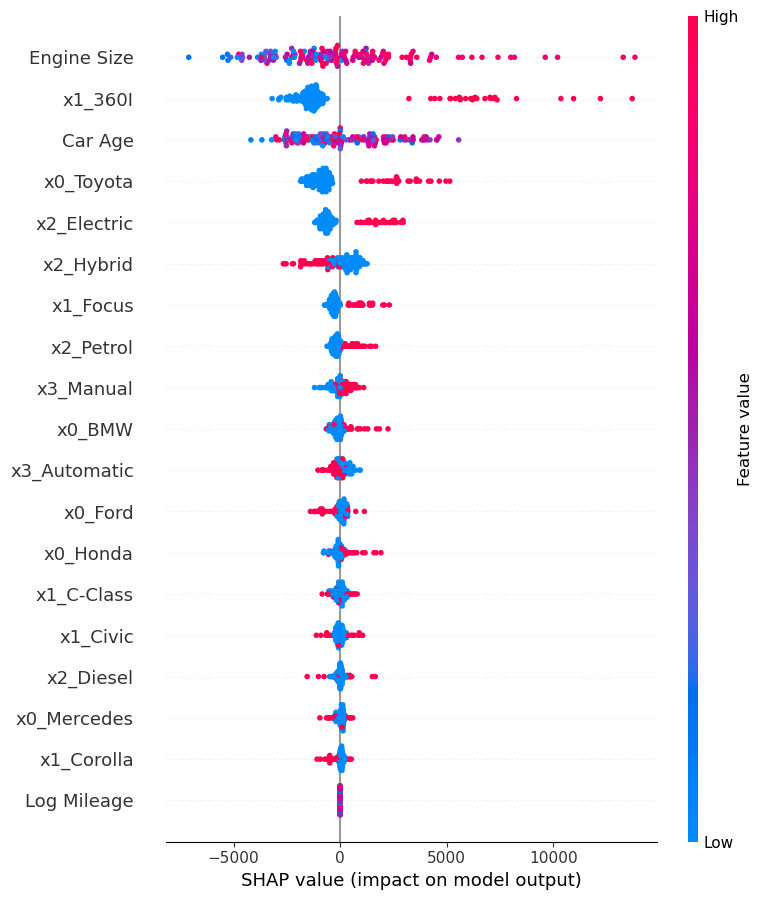

In [25]:
# SHAP for tree models
import shap
# Sample to keep computation reasonable
X_sample = holdout_X.sample(150, random_state=42)

# Transform features explicitly
X_sample_transformed = (
    final_model.named_steps["preprocessor"]
    .transform(X_sample)
)

# Create explainer on the trained tree model
explainer = shap.Explainer(
    final_model.named_steps["model"],
    X_sample_transformed
)

# Disable strict additivity check (EXPECTED for tree ensembles)
shap_values = explainer(
    X_sample_transformed,
    check_additivity=False
)

feature_names = get_feature_names(final_model, X)

shap.summary_plot(
    shap_values,
    features=X_sample_transformed,
    feature_names=feature_names
)

## SHAP/FI/PI Summary – Model Behavior Interpretation

The SHAP summary plot explains the global impact of features on predicted car prices.  
Features are ordered by importance from top to bottom, while color represents feature magnitude  
(**blue = low values, red = high values**).

### 1. Engine Size is the dominant driver of price

Engine Size has the widest SHAP value spread, making it the most influential feature.

- Larger engine sizes (red points) strongly increase predicted prices  
- Smaller engines (blue points) reduce predicted prices  
- The relationship is consistent and monotonic across observations  

**Interpretation:**  
Engine capacity is the strongest signal of vehicle value, reflecting performance, power, and market perception.

### 2. Specific car models create strong upward shifts

Models such as **360i, C-Class, Civic, and Corolla** show noticeable positive SHAP impacts.

- Presence of these models pushes predictions upward  
- Their influence is meaningful but still smaller than Engine Size  

**Interpretation:**  
Certain models command a premium beyond brand alone, likely due to reliability, trim level, and market demand.

### 3. Car Age negatively impacts price

Car Age shows a clear inverse relationship with price.

- Older cars (higher car age) reduce predicted price  
- Newer cars consistently increase predicted price  

**Interpretation:**  
The model correctly captures real-world depreciation in a smooth and stable manner.

### 4. Brand effects exist but are secondary

Brands such as **Toyota, BMW, Ford, Honda, and Mercedes** appear in the mid-range of importance.

- Brand presence slightly increases price  
- Brand impact is weaker than physical attributes and model-specific effects  

**Interpretation:**  
The model avoids overpricing vehicles based purely on brand reputation.

### 5. Transmission type affects value

Transmission features show asymmetric effects:

- Automatic transmission increases predicted price  
- Manual transmission generally reduces predicted price  

**Interpretation:**  
Market preference favors convenience, aligning with modern resale behavior.

### 6. Fuel type has conditional influence

Fuel-related features (**Petrol, Diesel, Hybrid, Electric**) show moderate but mixed effects.

- No fuel type dominates independently  
- Effects depend on interaction with engine size, mileage, and car age  

**Interpretation:**  
Fuel type influences perceived operating cost rather than base vehicle value.

### 7. Log Mileage has limited standalone impact

Log-transformed mileage appears near the bottom of the feature importance ranking.

- Extreme mileage values still impact price  
- Mid-range mileage contributes little marginal change  

**Interpretation:**  
Mileage matters most at extremes, justifying the log transformation applied during feature engineering.

## Overall Conclusion

The SHAP analysis confirms that the model prioritizes **physical vehicle characteristics**
(engine size, age, mileage) over branding.

This behavior mirrors real-world car valuation logic, indicating a **robust, interpretable,
and deployment-ready model**.

In [26]:
import joblib
# Save final model in current notebook folder
joblib.dump(final_model, "final_car_price_pipeline.joblib", compress=3)
print("Final production pipeline saved successfully")

Final production pipeline saved successfully
